# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import math
import glob
import os

# Import Data

In [2]:
# Read in the data
path = 'Data/'
files = [os.path.join(path, file) for file in os.listdir(path) if file.startswith('property_transactions_') and file.endswith('.csv')]
print(len(files), "files found.")
df_trans = pd.concat((pd.read_csv(file) for file in files), ignore_index=True)
# Remove duplicates
df_trans = df_trans.drop_duplicates()
df_trans['contractYear'] = df_trans['contractDate'].apply(lambda x: x % 100 + 2000)
df_trans['contractMonth'] = df_trans['contractDate'].apply(lambda x: x // 100)
df_trans['tenure'] = df_trans['tenure'].str.lower()     # Convert to lowercase for consistency
df_trans['tenureDuration'] = df_trans['tenure'].apply(lambda x: np.inf if 'freehold' in str(x) else int(x.split(' ')[0]) if isinstance(x, str) and len(x.split(' ')) > 1 else np.nan)      # If 'freehold' then 0, if NaN then NaN
df_trans['tenureStartYear'] = df_trans['tenure'].apply(lambda x: int(x.split(' ')[-1]) if isinstance(x, str) and len(x.split(' ')) > 3 else np.nan)     # If 'freehold' or '99 years lease' then nan
df_trans['tenureRemaining'] = df_trans.apply(lambda x: np.inf if 'freehold' in str(x['tenure']) else (x['tenureDuration'] - (x['contractYear'] - x['tenureStartYear'])) if not pd.isna(x['tenureStartYear']) else np.nan, axis=1)

group_cols = ["project", "street", "district", "area", "x", "y", "typeOfArea", "propertyType", 'tenureStartYear', "marketSegment"]

df_trans = df_trans.sort_values(by=group_cols+["contractYear"]).reset_index(drop=True)
df_trans = (
    df_trans.groupby(group_cols+["contractYear"])
    .agg(
        mean_price=("price", "mean"),
        transaction_count=("price", "count")
    )
    .reset_index()
)
df_trans["mean_price"] = df_trans["mean_price"].round(2)
df_trans['price_psm'] = df_trans['mean_price'] / df_trans['area']
df_trans['price_psm'] = df_trans['price_psm'].round(2)

df_trans.head()

4 files found.


,project,street,district,area,x,y,typeOfArea,propertyType,tenureStartYear,marketSegment,contractYear,mean_price,transaction_count,price_psm
0,1 CANBERRA,CANBERRA DRIVE,27,87.0,27611.4486,46578.21809,Strata,Executive Condominium,2012.0,OCR,2020,840000.00,1,9655.17
1,1 CANBERRA,CANBERRA DRIVE,27,87.0,27611.4486,46578.21809,Strata,Executive Condominium,2012.0,OCR,2021,884962.67,3,10171.98
2,1 CANBERRA,CANBERRA DRIVE,27,87.0,27611.4486,46578.21809,Strata,Executive Condominium,2012.0,OCR,2023,1109000.00,2,12747.13
3,1 CANBERRA,CANBERRA DRIVE,27,87.0,27611.4486,46578.21809,Strata,Executive Condominium,2012.0,OCR,2025,1230000.00,1,14137.93
4,1 CANBERRA,CANBERRA DRIVE,27,88.0,27611.4486,46578.21809,Strata,Executive Condominium,2012.0,OCR,2020,873571.43,7,9926.95


In [3]:
# Read in the data
path = 'Data/Rental/'
files = [os.path.join(path, file) for file in os.listdir(path) if file.startswith('Private Residential Property Rental Index') and file.endswith('.csv')]
print(len(files), "files found.")
rental_index = pd.concat((pd.read_csv(file) for file in files), ignore_index=True)
rental_index["year"] = rental_index["quarter"].apply(lambda x: int(x.split('-')[0]))
rental_index = rental_index[rental_index['year']>=2020]
rental_index["quarter"] = rental_index["quarter"].apply(lambda x: int(x.split('Q')[-1]))
rental_index = rental_index.sort_values(by=["year", "quarter"]).reset_index(drop=True)
rental_index.head()

1 files found.


,quarter,property_type,locality,index,year
0,1,All Residential,Whole Island,105.6,2020
1,1,Landed,Whole Island,94.6,2020
2,1,Non-Landed,Whole Island,107.1,2020
3,1,Non-Landed,Core Central Region,105.6,2020
4,1,Non-Landed,Rest of Central Region,110.1,2020


In [4]:
# Read in the data
path = 'Data/Rental/'
files = [os.path.join(path, file) for file in os.listdir(path) if file.startswith('property_rentals') and file.endswith('.csv')]
print(len(files), "files found.")
df_rental = pd.concat((pd.read_csv(file) for file in files), ignore_index=True)
df_rental['contractYear'] = df_rental['leaseDate'].apply(lambda x: x % 100 + 2000)
print(df_rental.columns)
group_cols = ["project", "street", "district", "propertyType", "areaSqm"]
df_rental = df_rental.sort_values(by=group_cols+["contractYear"]).reset_index(drop=True)
df_rental = (
    df_rental.groupby(group_cols+["contractYear"])
    .agg(
        mean_rent=("rent", "mean"),
        rent_count=("rent", "count")
    )
    .reset_index()
)
df_rental.head()

21 files found.


C:\Users\Porkc\AppData\Local\Temp\ipykernel_15076\2009480933.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_rental = pd.concat((pd.read_csv(file) for file in files), ignore_index=True)


Index(['y', 'x', 'street', 'project', 'noOfBedRoom', 'rent', 'propertyType',
       'areaSqft', 'areaSqm', 'leaseDate', 'district', 'contractYear'],
      dtype='object')


,project,street,district,propertyType,areaSqm,contractYear,mean_rent,rent_count
0,# 1 LOFT,LORONG 24 GEYLANG,14.0,Non-landed Properties,120-130,2020.0,3150.0,1
1,# 1 LOFT,LORONG 24 GEYLANG,14.0,Non-landed Properties,120-130,2021.0,3375.0,4
2,# 1 LOFT,LORONG 24 GEYLANG,14.0,Non-landed Properties,120-130,2022.0,4000.0,1
3,# 1 LOFT,LORONG 24 GEYLANG,14.0,Non-landed Properties,120-130,2023.0,4800.0,1
4,# 1 LOFT,LORONG 24 GEYLANG,14.0,Non-landed Properties,120-130,2024.0,4650.0,2


In [5]:
print(len(df_rental))
print(len(df_rental['project'].unique()), "unique projects")
print(len(df_rental))
print(len(df_rental['project'].unique()), "unique projects")

76630
3193 unique projects
76630
3193 unique projects


# Investigating Rental Prices

In [6]:
df = df_rental.copy()
df = df.sort_values(by=['project', 'street', 'district', 'areaSqm', 'propertyType', 'contractYear'])

# Compute yearly percent change in mean rent for each project
df['perc_change'] = df.groupby(['project', 'street', 'district', 'areaSqm', 'propertyType'])['mean_rent'].pct_change() * 100

# Aggregate mean percent change by year (excluding NaN)
avg_changes_all = (
    df.groupby('contractYear')['perc_change']
    .mean()
    .dropna()
)

df.head()

,project,street,district,propertyType,areaSqm,contractYear,mean_rent,rent_count,perc_change
0,# 1 LOFT,LORONG 24 GEYLANG,14.0,Non-landed Properties,120-130,2020.0,3150.0,1,NaN
1,# 1 LOFT,LORONG 24 GEYLANG,14.0,Non-landed Properties,120-130,2021.0,3375.0,4,7.142857
2,# 1 LOFT,LORONG 24 GEYLANG,14.0,Non-landed Properties,120-130,2022.0,4000.0,1,18.518519
3,# 1 LOFT,LORONG 24 GEYLANG,14.0,Non-landed Properties,120-130,2023.0,4800.0,1,20.000000
4,# 1 LOFT,LORONG 24 GEYLANG,14.0,Non-landed Properties,120-130,2024.0,4650.0,2,-3.125000


In [7]:
avg_changes_all.head()

contractYear
2021.0     5.849354
2022.0    20.920220
2023.0    24.671578
2024.0     2.194678
2025.0     2.450717
Name: perc_change, dtype: float64

In [8]:
df_landed = df[(df['propertyType'] != 'Non-landed Properties') & (df['propertyType'] != 'Executive Condominium')]
df_landed = df_landed.sort_values(by=['project', 'street', 'district', 'areaSqm', 'propertyType', 'contractYear'])

# Compute yearly percent change in mean rent for each project
df_landed['perc_change'] = df_landed.groupby(['project', 'street', 'district', 'areaSqm', 'propertyType'])['mean_rent'].pct_change() * 100

# Aggregate mean percent change by year (excluding NaN)
avg_changes_landed = (
    df_landed.groupby('contractYear')['perc_change']
    .mean()
    .dropna()
)

avg_changes_landed.head(n=10)

contractYear
2021.0    12.096704
2022.0    24.615793
2023.0    37.145214
2024.0     9.110855
2025.0     4.288621
Name: perc_change, dtype: float64

In [9]:
df_nonlanded = df[(df['propertyType'] == 'Non-landed Properties') | (df['propertyType'] == 'Executive Condominium')]
df_nonlanded = df_nonlanded.sort_values(by=['project', 'street', 'district', 'areaSqm', 'propertyType', 'contractYear'])

# Compute yearly percent change in mean rent for each project
df_nonlanded['perc_change'] = df_nonlanded.groupby(['project', 'street', 'district', 'areaSqm', 'propertyType'])['mean_rent'].pct_change() * 100

# Aggregate mean percent change by year (excluding NaN)
avg_changes_nonlanded = (
    df_nonlanded.groupby('contractYear')['perc_change']
    .mean()
    .dropna()
)

avg_changes_nonlanded.head()

contractYear
2021.0     5.190620
2022.0    20.176501
2023.0    22.871427
2024.0     0.823761
2025.0     2.046230
Name: perc_change, dtype: float64

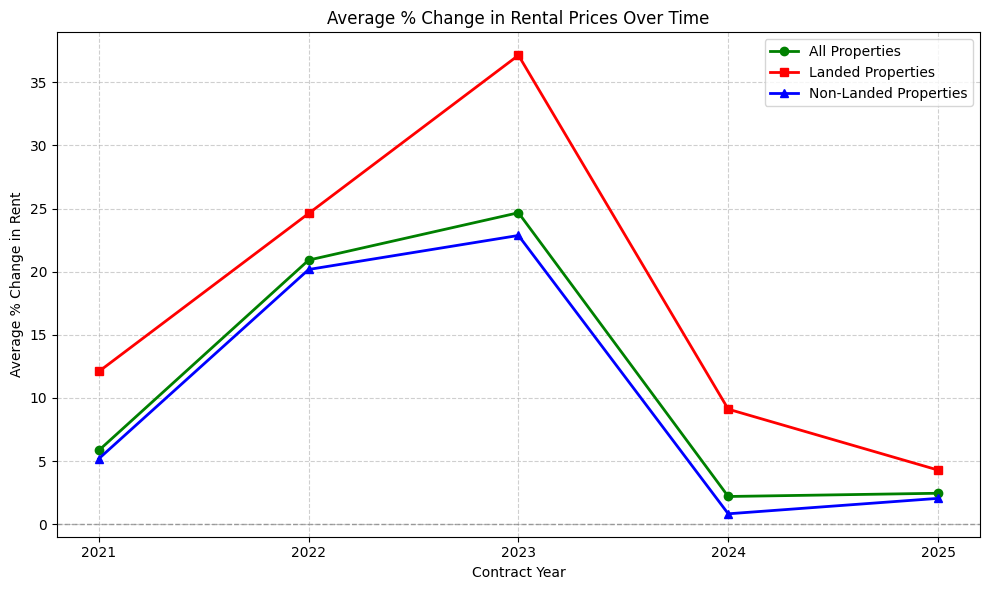

In [10]:
# Define consistent colors for clarity
colors = {
    'All Properties': 'green',
    'Landed Properties': 'red',
    'Non-Landed Properties': 'blue' 
}

plt.figure(figsize=(10, 6))

# Plot each trend line
plt.plot(avg_changes_all.index, avg_changes_all.values,
         marker='o', linewidth=2, color=colors['All Properties'], label='All Properties')
plt.plot(avg_changes_landed.index, avg_changes_landed.values,
         marker='s', linewidth=2, color=colors['Landed Properties'], label='Landed Properties')
plt.plot(avg_changes_nonlanded.index, avg_changes_nonlanded.values,
         marker='^', linewidth=2, color=colors['Non-Landed Properties'], label='Non-Landed Properties')

# Add a horizontal reference line at 0%
plt.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.title('Average % Change in Rental Prices Over Time')
plt.xlabel('Contract Year')
plt.ylabel('Average % Change in Rent')
plt.legend()
plt.xticks(avg_changes_all.index)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


# Investigating Rental Index

In [11]:
rental_index.head(n=10)

,quarter,property_type,locality,index,year
0,1,All Residential,Whole Island,105.6,2020
1,1,Landed,Whole Island,94.6,2020
2,1,Non-Landed,Whole Island,107.1,2020
3,1,Non-Landed,Core Central Region,105.6,2020
4,1,Non-Landed,Rest of Central Region,110.1,2020
5,1,Non-Landed,Outside Central Region,105.5,2020
6,2,All Residential,Whole Island,104.3,2020
7,2,Landed,Whole Island,92.4,2020
8,2,Non-Landed,Whole Island,105.9,2020
9,2,Non-Landed,Core Central Region,105.0,2020


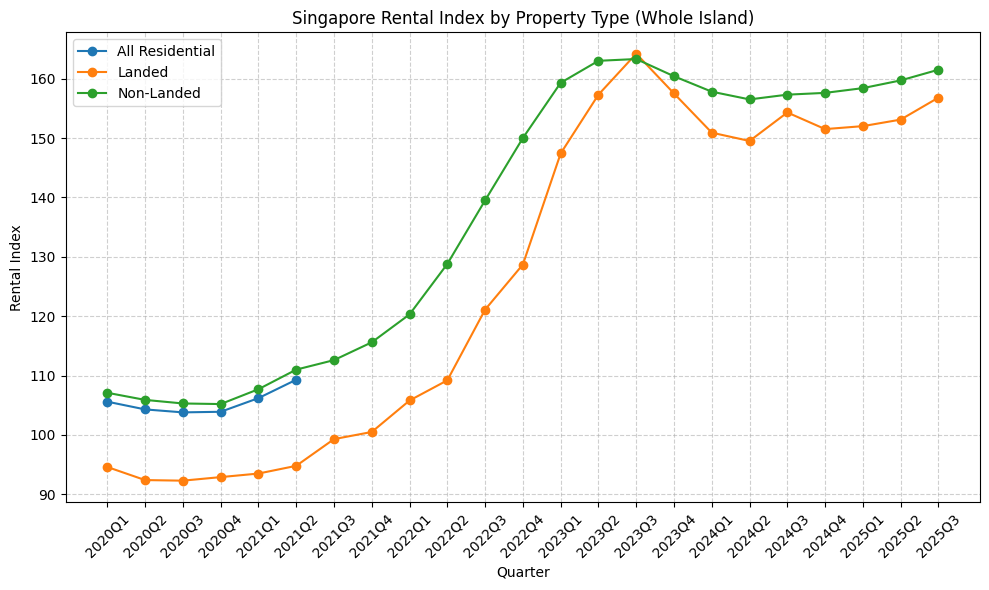

In [12]:
rental_index['date'] = (
    rental_index['year'].astype(str) + 'Q' + rental_index['quarter'].astype(str)
)
rental_index['date'] = pd.PeriodIndex(rental_index['date'], freq='Q')

plt.figure(figsize=(10,6))
subset = rental_index[rental_index['locality'] == 'Whole Island']

for ptype in subset['property_type'].unique():
    data = subset[subset['property_type'] == ptype]
    plt.plot(data['date'].astype(str), data['index'], marker='o', label=ptype)

plt.title('Singapore Rental Index by Property Type (Whole Island)')
plt.xlabel('Quarter')
plt.ylabel('Rental Index')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

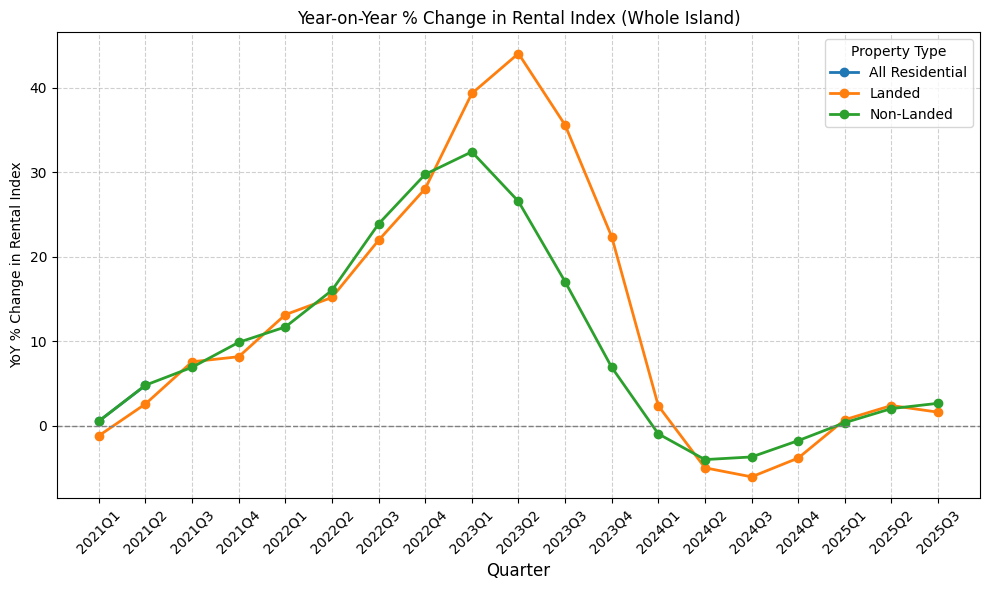

In [13]:
# Ensure proper sorting
rental_index = rental_index.sort_values(by=['property_type', 'locality', 'year', 'quarter'])

# Year-on-Year (YoY) % change — compare same quarter last year (shift by 4 quarters)
rental_index['perc_change_yoy'] = (
    rental_index.groupby(['property_type', 'locality'])['index']
    .pct_change(periods=4) * 100
)

plt.figure(figsize=(10,6))
subset = rental_index[rental_index['locality'] == 'Whole Island']

for ptype in subset['property_type'].unique():
    data = subset[subset['property_type'] == ptype]
    plt.plot(
        data['date'].astype(str),
        data['perc_change_yoy'],
        marker='o',
        linewidth=2,
        label=ptype
    )

plt.title('Year-on-Year % Change in Rental Index (Whole Island)')
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('YoY % Change in Rental Index')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.legend(title='Property Type')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- The shape of YoY percentage change in rental index is similar to the % change in rental price we obtained using the property_rentals dataset

# Map Rental Data to Property Transaction Data

In [14]:
def parse_range(val):
    if isinstance(val, str) and "-" in val:
        a, b = val.split("-")
        return float(a), float(b)
    try:
        v = float(val)
        return v, v
    except:
        return np.nan, np.nan

df_rental[["area_min", "area_max"]] = df_rental["areaSqm"].apply(lambda x: pd.Series(parse_range(x)))


In [15]:
datasample = pd.merge(
    df_rental,
    df_trans,
    on=["street", "project", "district", "contractYear"],
    how="inner",
    suffixes=("_rent", "_sale")
)

datasample = datasample[
    (datasample["area"] >= datasample["area_min"]) &
    (datasample["area"] <= datasample["area_max"])
]

group_cols = ["project", "street", "marketSegment", "district", "propertyType_rent", "propertyType_sale", "typeOfArea", "areaSqm", "tenureStartYear", "contractYear", 'mean_rent', 'rent_count']

datasample = (
    datasample
    .groupby(group_cols, as_index=False)
    .agg({
        "mean_price": "mean",
        "transaction_count": "sum",
        "price_psm": "mean",
        "tenureStartYear": "first",
        "marketSegment": "first",
        "propertyType_sale": "first",
        "typeOfArea": "first",
        "area" : "first"
    })
)

datasample = datasample.drop_duplicates()


In [16]:
print(len(datasample))
print(len(datasample['project'].unique()), "unique projects")

13611
744 unique projects


In [17]:
# Reorder columns for clarity
datasample = datasample[[
    # Project Information
    "project", "street", "marketSegment", "district",
    # Property Type
    "propertyType_rent", "propertyType_sale", "typeOfArea",
    "areaSqm", "area", "tenureStartYear", "contractYear",
    # Rental Details
    "mean_rent", "rent_count", 
    # Sale Details
     "mean_price", "transaction_count", "price_psm", 
]]
datasample = datasample.sort_values(by=["project", "street", "marketSegment", "district", "propertyType_rent", "propertyType_sale", "typeOfArea", "areaSqm", "tenureStartYear", "contractYear"])

# Investigate Relationship Between Rental And Property Price

In [18]:
# Clean numeric fields
datasample["mean_rent"] = pd.to_numeric(datasample["mean_rent"], errors="coerce")
datasample["mean_price"] = pd.to_numeric(datasample["mean_price"], errors="coerce")
datasample["price_psm"] = pd.to_numeric(datasample["price_psm"], errors="coerce")
datasample["area"] = pd.to_numeric(datasample["area"], errors="coerce")

datasample["gross_rental_yield"] = (datasample["mean_rent"] * 12) / datasample["mean_price"]

In [19]:
datasample.head()

,project,street,marketSegment,district,propertyType_rent,propertyType_sale,typeOfArea,areaSqm,area,tenureStartYear,contractYear,mean_rent,rent_count,mean_price,transaction_count,price_psm,gross_rental_yield
0,1 CANBERRA,CANBERRA DRIVE,OCR,27.0,Executive Condominium,Executive Condominium,Strata,110-120,112.0,2012.0,2020.0,4000.0,1,1.055887e+06,9,9035.516000,0.045459
1,1 CANBERRA,CANBERRA DRIVE,OCR,27.0,Executive Condominium,Executive Condominium,Strata,110-120,112.0,2012.0,2021.0,3175.0,2,1.135265e+06,18,9717.248571,0.033560
2,1 CANBERRA,CANBERRA DRIVE,OCR,27.0,Executive Condominium,Executive Condominium,Strata,110-120,116.0,2012.0,2023.0,3650.0,4,1.541750e+06,7,13117.487500,0.028409
3,1 CANBERRA,CANBERRA DRIVE,OCR,27.0,Executive Condominium,Executive Condominium,Strata,110-120,116.0,2012.0,2024.0,4200.0,2,1.538898e+06,9,13044.487500,0.032751
4,1 CANBERRA,CANBERRA DRIVE,OCR,27.0,Executive Condominium,Executive Condominium,Strata,130-140,134.0,2012.0,2021.0,2025.0,4,1.370000e+06,1,10223.880000,0.017737


## Investigating the link between mean_price and mean_rent

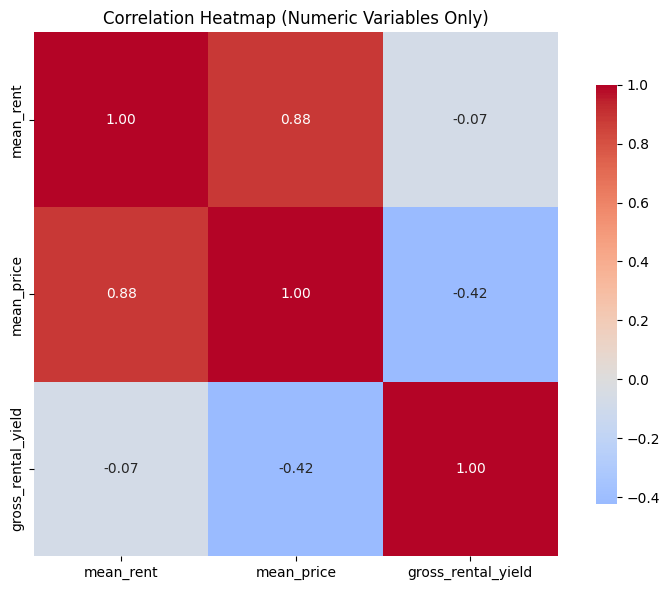

In [20]:
# Calculate correlation matrix
corr = datasample[["mean_rent", "mean_price", "gross_rental_yield"]].corr()

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            center=0,
            square=True,
            cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap (Numeric Variables Only)')
plt.tight_layout()
plt.show()

- Strong correlation between property price and rent price

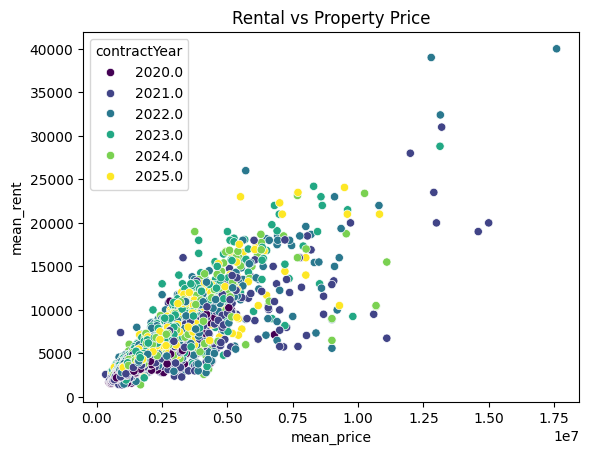

In [29]:
sns.scatterplot(
    data=datasample,
    x="mean_price", y="mean_rent",
    hue="contractYear", palette="viridis"
)
plt.title("Rental vs Property Price")
plt.show()


<Figure size 600x400 with 0 Axes>

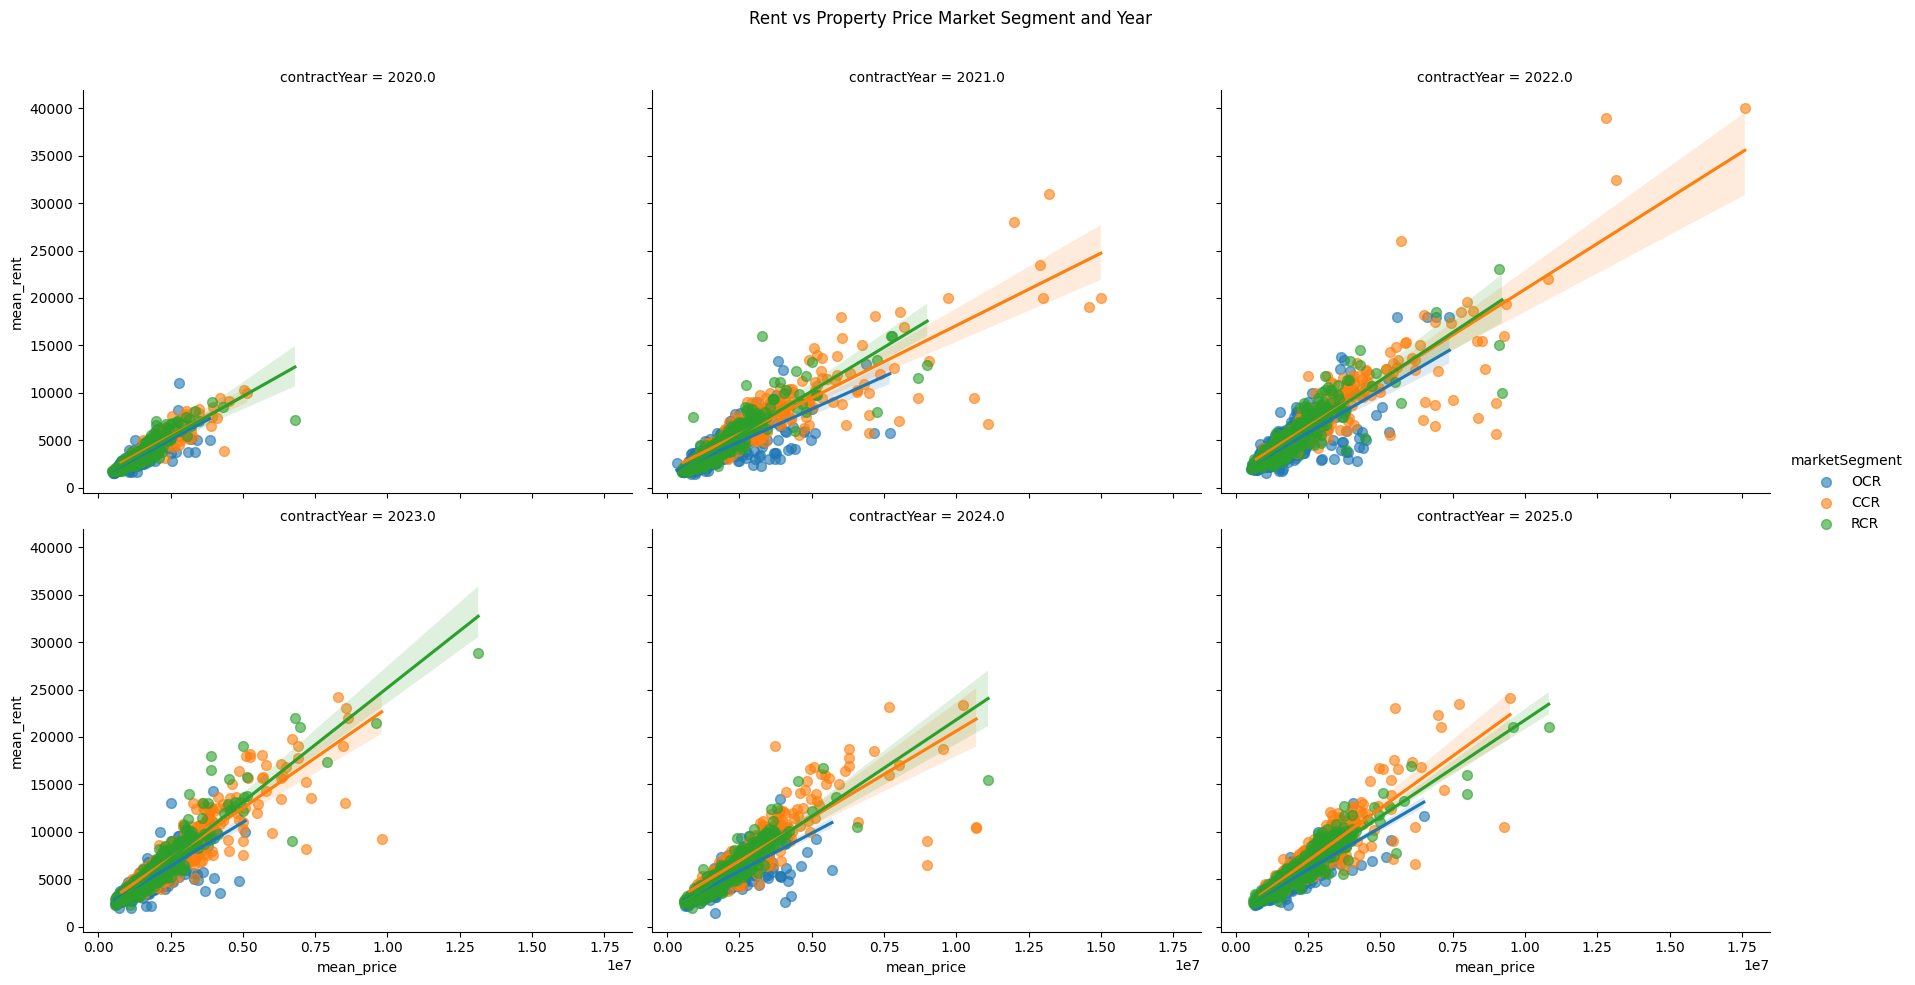

In [25]:
plt.figure(figsize=(6,4))
sns.lmplot(
    data=datasample,
    x="mean_price",
    y="mean_rent",
    hue="marketSegment",
    col="contractYear",
    col_wrap=3,             # 2 columns per row
    height=5,               # height per subplot (inches)
    aspect=1.2,             # width-to-height ratio
    scatter_kws={"alpha": 0.6, "s": 50},  # cleaner scatter
)

plt.subplots_adjust(top=0.9)
plt.suptitle("Rent vs Property Price Market Segment and Year")
plt.show()


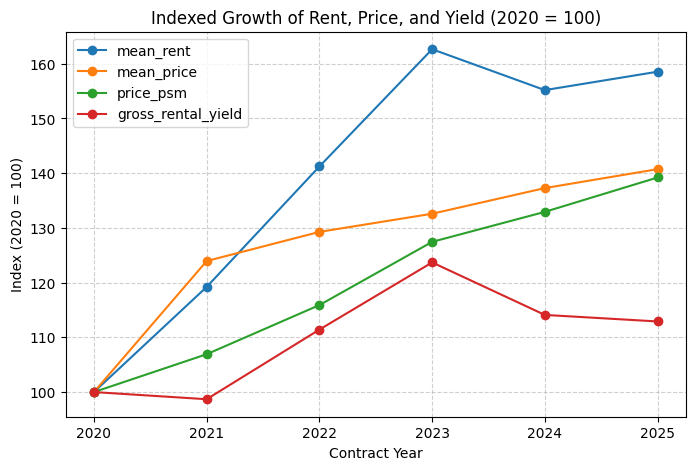

In [ ]:
avg_trends = (
    datasample.groupby("contractYear")[["mean_rent", "mean_price", "price_psm", "gross_rental_yield"]]
    .mean()
)

# Using 2020 as the base year for indexing
normalized = avg_trends / avg_trends.iloc[0] * 100

normalized.plot(marker='o', figsize=(8,5))
plt.title('Indexed Growth of Rent, Price, and Yield (2020 = 100)')
plt.xlabel('Contract Year')
plt.ylabel('Index (2020 = 100)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


- Rent increased rapidly from 2020-2023
- Price of property increased at a slower rate
- Price psm increased slower than price of property, possible reason could be that more large properties were sold during these periods. 